In [1]:
x=1

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (6, 6)

In [3]:
adata = sc.read('../../../pipeline/data/multigrate_mil/mtg3_clean_healthy_covid_embed/10394725ec_adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 362426 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    var: 'modality'
    uns: 'Site_colors', 'Status_on_day_collection_summary_colors', '_scvi_manager_uuid', '_scvi_uuid', 'full_clustering_colors', 'initial_clustering_colors', 'modality_lengths', 'neighbors', 'patient_id_colors', 'umap'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'latent', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'
    layers: 'count

In [30]:
adata.obs['Status_on_day_collection_summary'].value_counts()

COVID      268673
Healthy     93753
Name: Status_on_day_collection_summary, dtype: int64

In [4]:
sc.set_figure_params(vector_friendly=True)

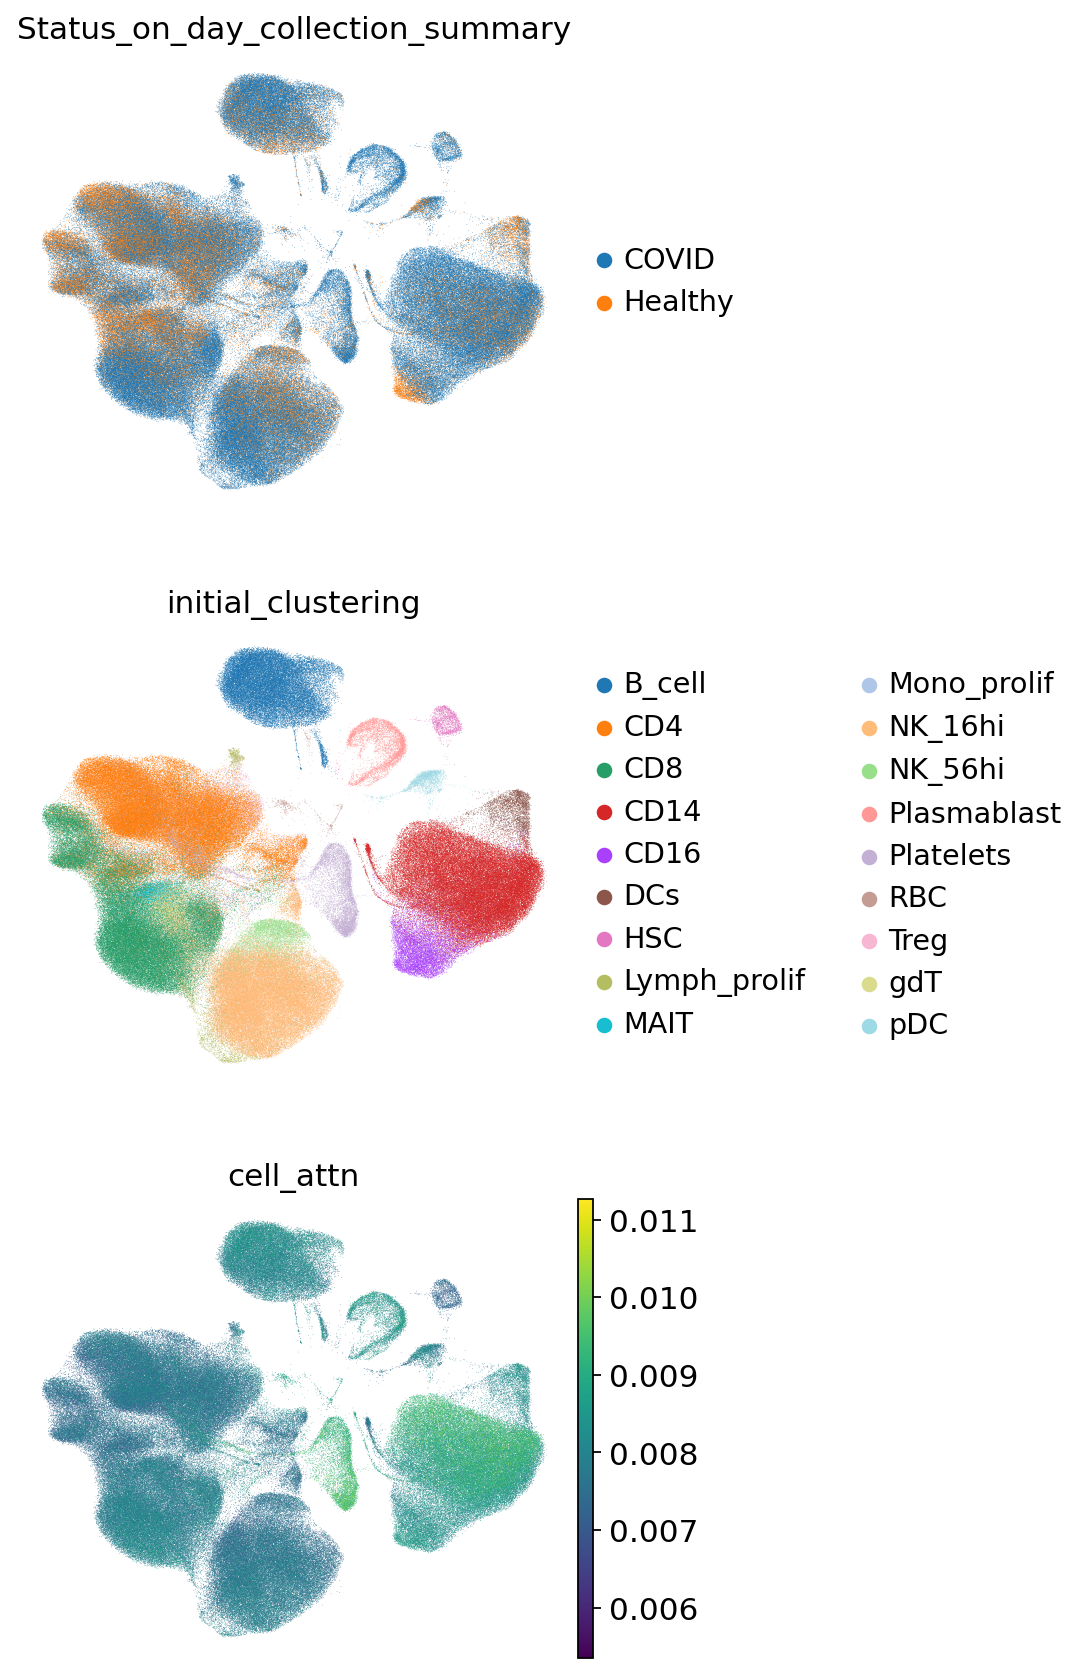

In [5]:
sc.pl.umap(
    adata,
    color=['Status_on_day_collection_summary', 'initial_clustering', 'cell_attn'],
    ncols=1,
    frameon=False,
)

-------- COVID -------


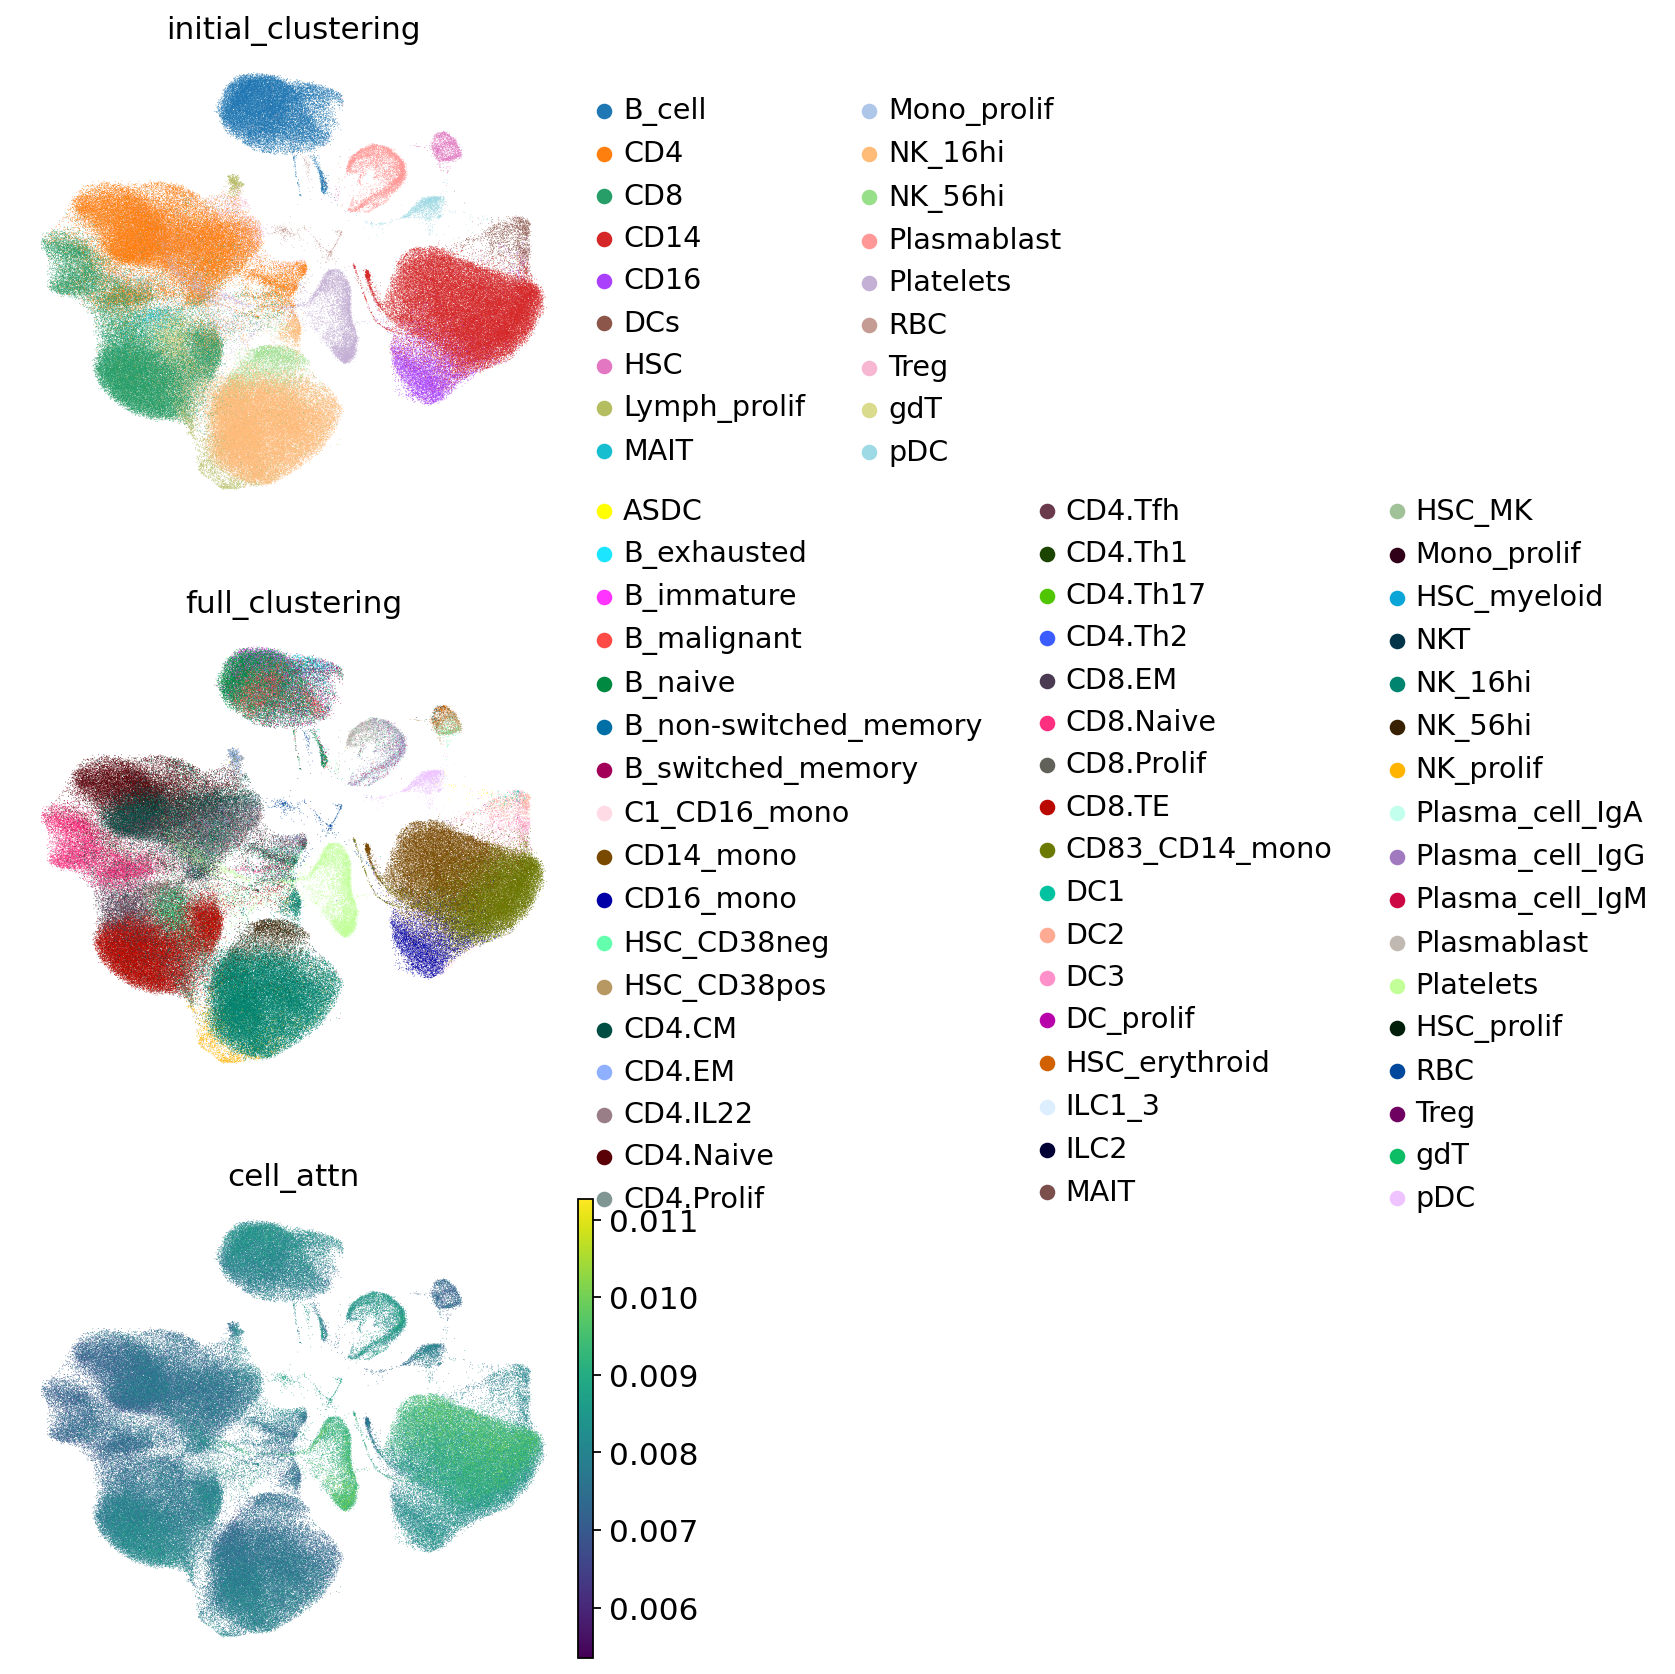

-------- Healthy -------


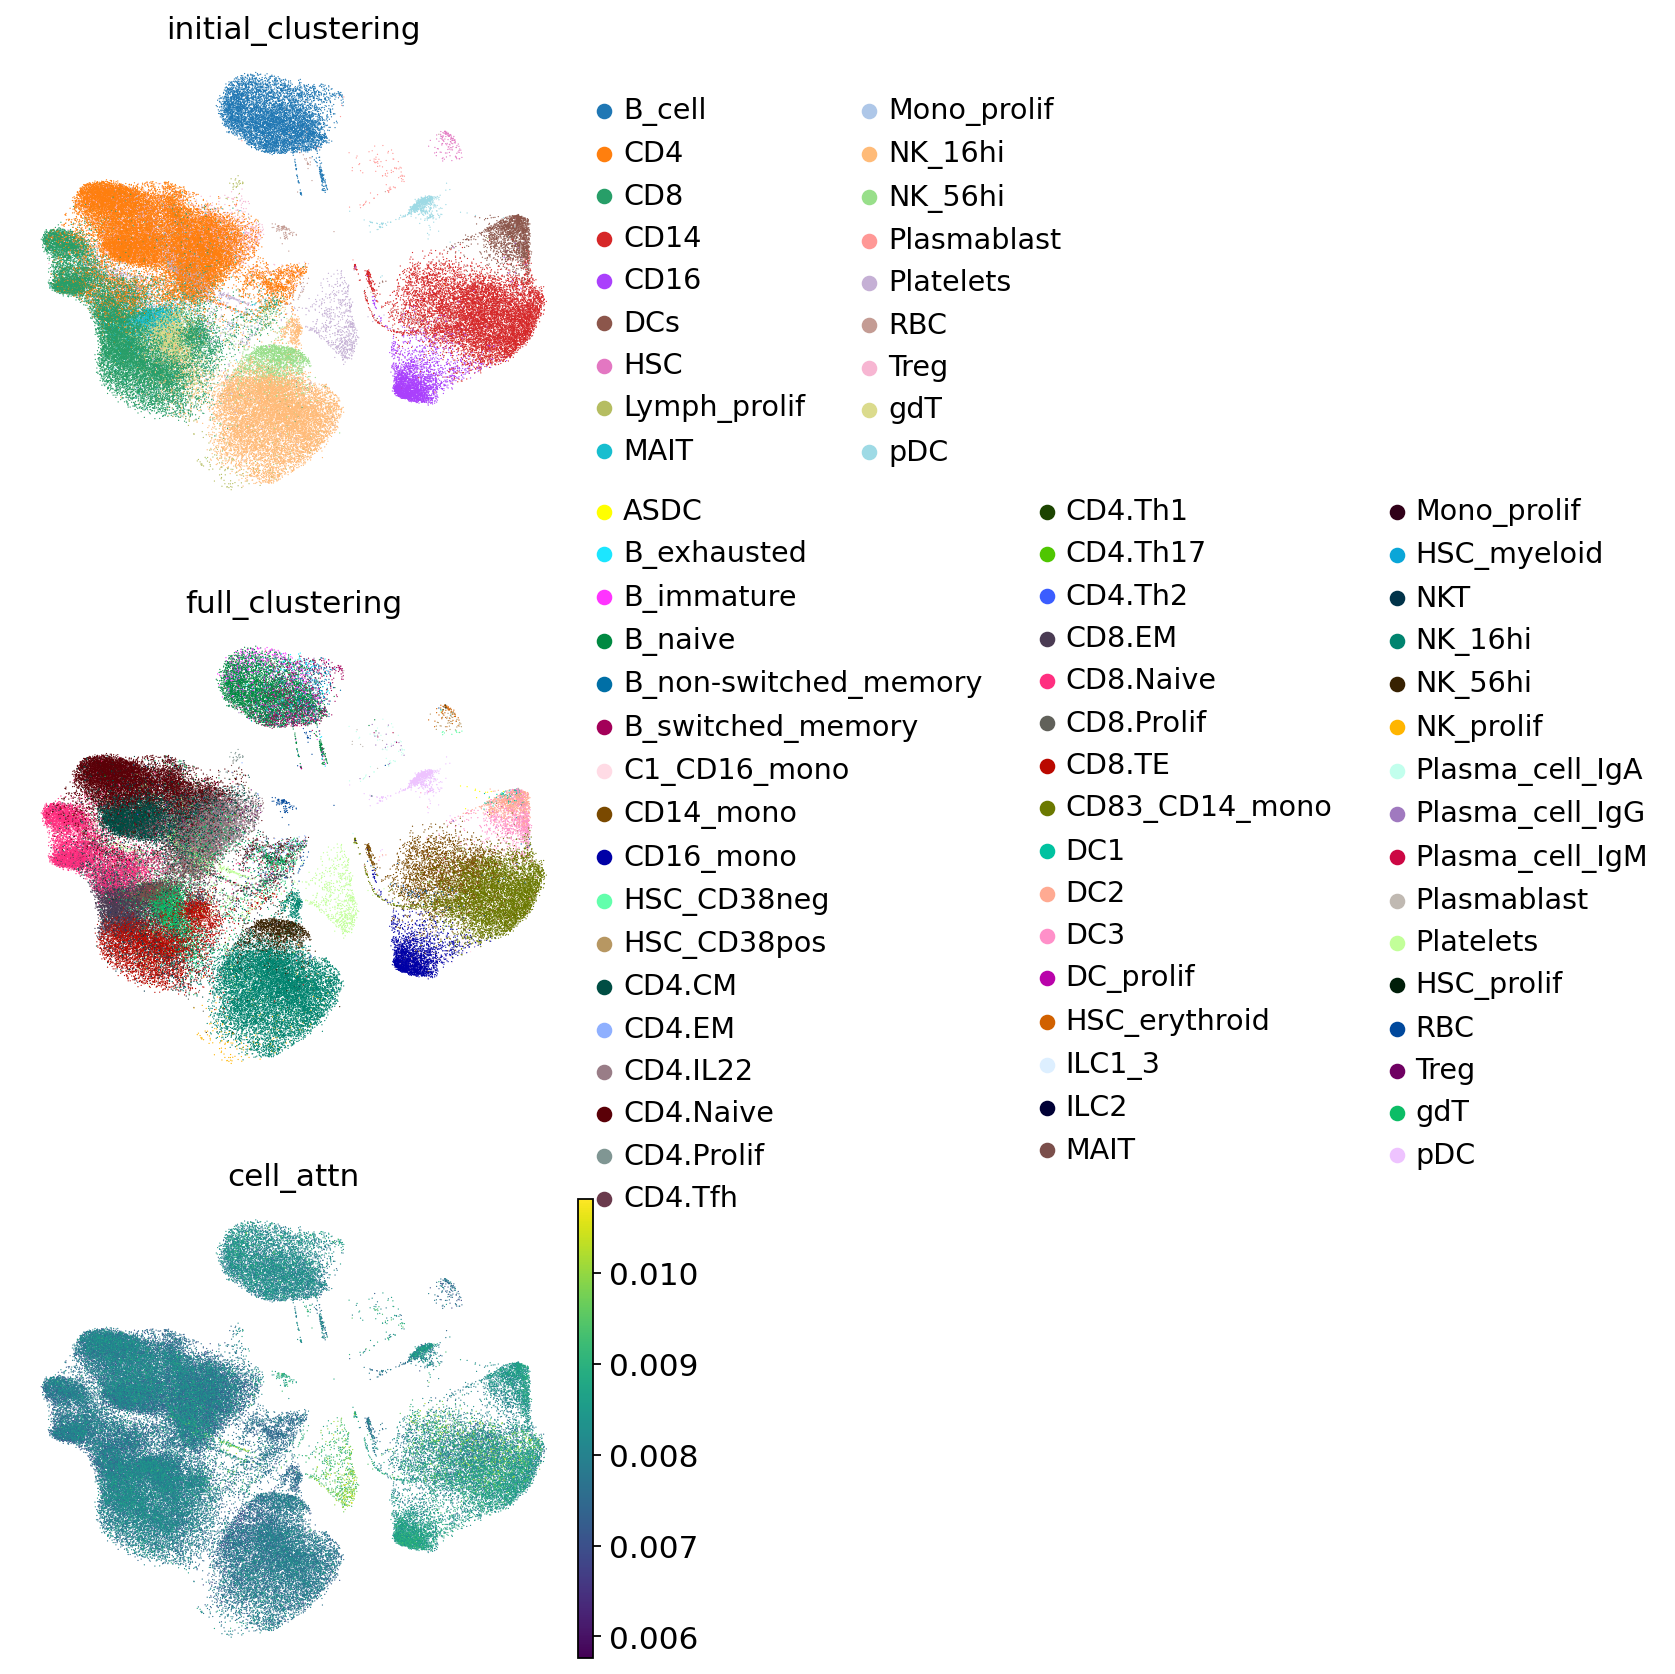

In [6]:
for cond in np.unique(adata.obs['Status_on_day_collection_summary']):
    adata_tmp = adata[adata.obs['Status_on_day_collection_summary'] == cond].copy()
    print(f'-------- {cond} -------')
    sc.pl.umap(
        adata_tmp,
        color=['initial_clustering', 'full_clustering', 'cell_attn'],
        ncols=1,
        frameon=False
    )

In [7]:
dfs = []
for cond in np.unique(adata.obs['Status_on_day_collection_summary']):
    adata_tmp = adata[adata.obs['Status_on_day_collection_summary'] == cond].copy()
    threshold_idx = int(len(adata_tmp) * 0.9)
    threshold_value = sorted(adata_tmp.obs['cell_attn'])[threshold_idx]
    adata_tmp.obs['group'] = 'all cells'
    adata_tmp.obs.loc[adata_tmp.obs['cell_attn'] >= threshold_value, 'group'] = 'top 10% cells'
    adata.obs[f'top_cells_{cond}'] = False
    adata.obs.loc[adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs_names, f'top_cells_{cond}'] = True
    adata.obs[f'top_cells_{cond}'] = adata.obs[f'top_cells_{cond}'].astype('category')
    dfs.append(adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs[['initial_clustering', 'Status_on_day_collection_summary']])

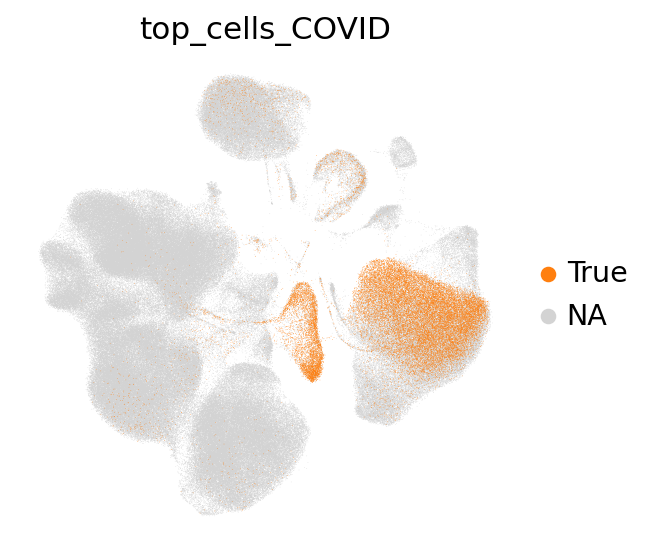

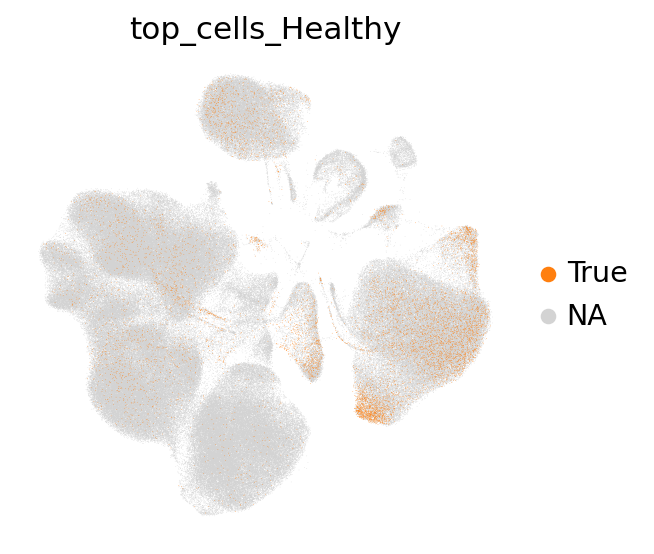

In [8]:
for cond in np.unique(adata.obs['Status_on_day_collection_summary']):
    sc.pl.umap(adata, color=[f'top_cells_{cond}'], groups=[True], frameon=False)

In [9]:
df = pd.concat(dfs)
df

initial_clustering Status_on_day_collection_summary
covid_index                                                                   
AAACCTGAGACCTTTG-MH9143327               CD14                            COVID
AAACCTGAGTGTTGAA-MH9143327               CD14                            COVID
AAACCTGCAAGCTGAG-MH9143327               CD14                            COVID
AAACCTGGTAAACGCG-MH9143327               CD14                            COVID
AAACCTGTCTACGAGT-MH9143327               CD14                            COVID
...                                       ...                              ...
BGCV15_TCTTCGGTCCTTCAAT-1           Platelets                          Healthy
BGCV15_TGTGTTTCAAGAGTCG-1                 CD4                          Healthy
BGCV15_TTCTCCTAGTATGACA-1              B_cell                          Healthy
BGCV15_TTGCCGTCAGTAGAGC-1                 CD4                          Healthy
BGCV15_TTTCCTCTCTGATACG-1                 CD4                          Healthy

[36244 rows x 2 columns]

In [10]:
df_group = df.groupby('Status_on_day_collection_summary').value_counts(normalize=True).mul(100)
df_group

Status_on_day_collection_summary  initial_clustering
COVID                             CD14                  72.186244
                                  Platelets             18.099598
                                  B_cell                 2.262915
                                  Plasmablast            2.181033
                                  CD16                   1.678577
                                  CD8                    1.138901
                                  RBC                    1.034688
                                  NK_16hi                0.509900
                                  Mono_prolif            0.253089
                                  CD4                    0.182373
                                  DCs                    0.133988
                                  pDC                    0.096769
                                  Lymph_prolif           0.085604
                                  gdT                    0.074438
                       

In [11]:
df_group = df_group.unstack().reindex(['Healthy', 'COVID'])

In [12]:
df_group

initial_clustering                  B_cell       CD14       CD16       CD4  \
Status_on_day_collection_summary                                             
Healthy                           9.918942  33.233788  14.419795  9.023038   
COVID                             2.262915  72.186244   1.678577  0.182373   

initial_clustering                     CD8       DCs       HSC  Lymph_prolif  \
Status_on_day_collection_summary                                               
Healthy                           7.252560  5.578072  0.010666      0.202645   
COVID                             1.138901  0.133988  0.003722      0.085604   

initial_clustering                    MAIT  Mono_prolif   NK_16hi   NK_56hi  \
Status_on_day_collection_summary                                              
Healthy                           0.714590          NaN  1.951792  0.245307   
COVID                             0.022331     0.253089  0.509900  0.007444   

initial_clustering                Plasmablast  Platelets       RBC      Treg  \
Status_on_day_collection_summary                                               
Healthy                              0.671928  10.761519  2.751706  0.767918   
COVID                                2.181033  18.099598  1.034688  0.048385   

initial_clustering                     gdT       pDC  
Status_on_day_collection_summary                      
Healthy                           1.322526  1.173208  
COVID                             0.074438  0.096769

In [13]:
color = []
for ct in df_group.columns:
    idx = list(adata.obs['initial_clustering'].cat.categories).index(ct)
    color.append(adata.uns['initial_clustering_colors'][idx])
len(color)

18

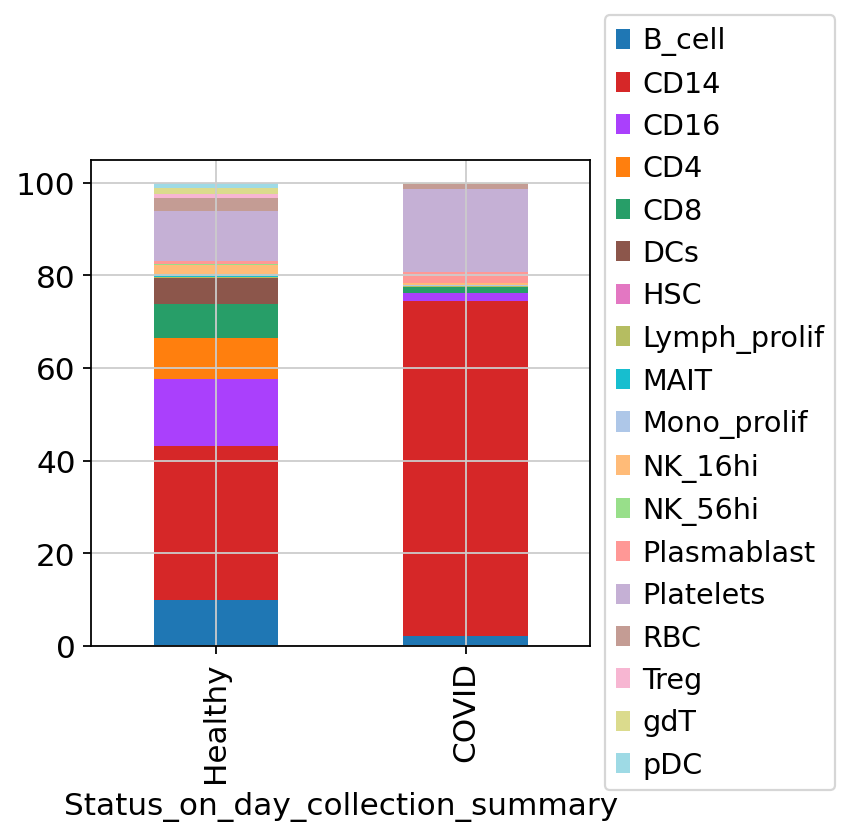

In [14]:
df_group.plot.bar(stacked=True, color=color).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [18]:
df_comp = adata.obs[['initial_clustering', 'Status_on_day_collection_summary']]
df_comp = df_comp.groupby('Status_on_day_collection_summary').value_counts(normalize=True).mul(100)

In [19]:
df_comp = df_comp.unstack().reindex(['Healthy', 'COVID'])

In [20]:
color = []
for ct in df_comp.columns:
    idx = list(adata.obs['initial_clustering'].cat.categories).index(ct)
    color.append(adata.uns['initial_clustering_colors'][idx])
len(color)

18

In [22]:
df_comp

initial_clustering                  B_cell        CD4        CD8       CD14  \
Status_on_day_collection_summary                                              
Healthy                           7.617890  30.150502  20.048425  10.075411   
COVID                             9.438239  19.811816  17.123418  19.212202   

initial_clustering                    CD16       DCs       HSC  Lymph_prolif  \
Status_on_day_collection_summary                                               
Healthy                           3.284162  2.059667  0.139729      0.286924   
COVID                             2.891991  0.732117  0.602963      1.366717   

initial_clustering                    MAIT  Mono_prolif    NK_16hi   NK_56hi  \
Status_on_day_collection_summary                                               
Healthy                           2.148198     0.002133  12.470001  2.185530   
COVID                             0.824794     0.060669  16.791043  1.646239   

initial_clustering                Plasmablast  Platelets       RBC      Treg  \
Status_on_day_collection_summary                                               
Healthy                              0.116263   2.056468  0.348789  2.495920   
COVID                                1.874398   3.309972  0.486837  1.902685   

initial_clustering                     gdT       pDC  
Status_on_day_collection_summary                      
Healthy                           3.831344  0.682645  
COVID                             1.300093  0.623807

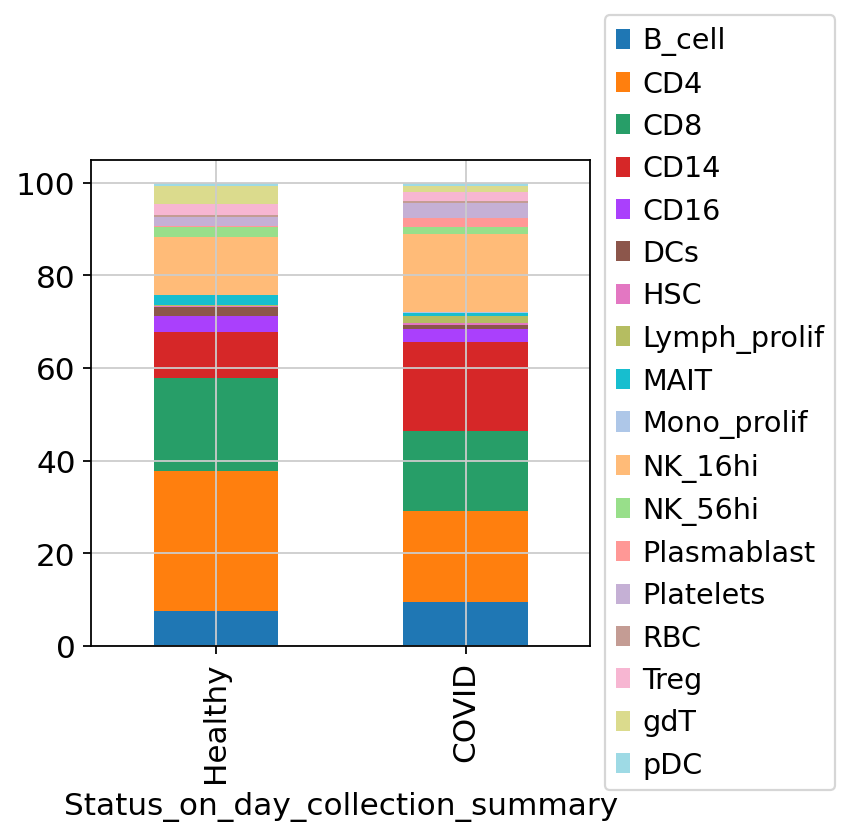

In [21]:
df_comp.plot.bar(stacked=True, color=color).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [28]:
adata.obs[['initial_clustering', 'cell_attn']].groupby('initial_clustering').agg('mean').sort_values('cell_attn')

cell_attn
initial_clustering           
HSC                  0.007229
CD4                  0.007407
NK_56hi              0.007421
Treg                 0.007439
NK_16hi              0.007513
MAIT                 0.007604
CD8                  0.007605
gdT                  0.007654
Lymph_prolif         0.007694
pDC                  0.007776
B_cell               0.007923
DCs                  0.008121
CD16                 0.008225
Plasmablast          0.008262
RBC                  0.008550
CD14                 0.008610
Mono_prolif          0.008736
Platelets            0.008812

In [15]:
mono = adata[adata.obs['initial_clustering'] == 'CD14'].copy()
mono

AnnData object with n_obs × n_vars = 61064 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn', 'top_cells_COVID', 'top_cells_Healthy'
    var: 'modality'
    uns: 'Site_colors', '_scvi_manager_uuid', '_scvi_uuid', 'full_clustering_colors', 'initial_clustering_colors', 'modality_lengths', 'neighbors', 'patient_id_colors', 'umap', 'top_cells_COVID_colors', 'top_cells_Healthy_colors'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'latent', 'latent_0', 'latent_1', 'la

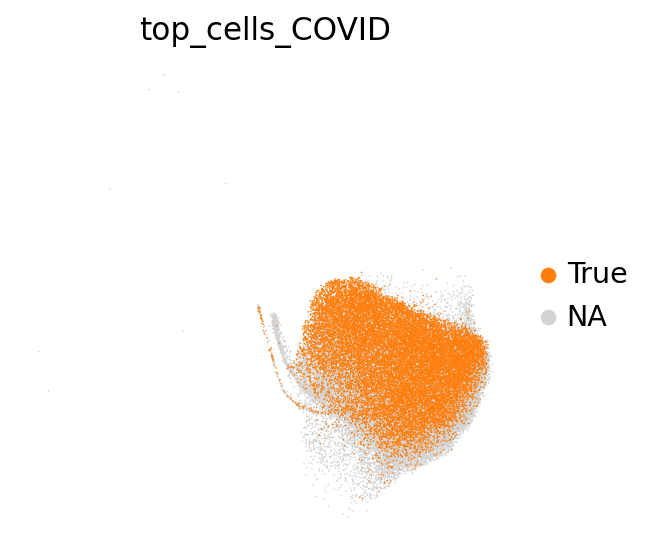

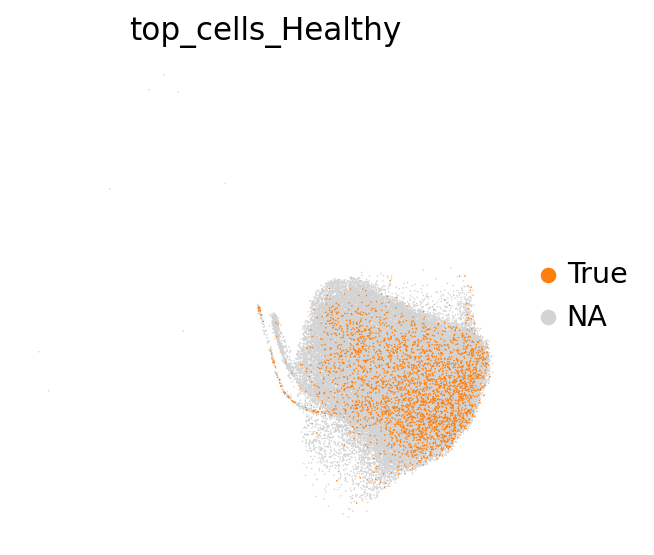

In [16]:
for cond in np.unique(mono.obs['Status_on_day_collection_summary']):
    sc.pl.umap(mono, color=[f'top_cells_{cond}'], groups=[True], frameon=False)

In [17]:
plat = adata[adata.obs['initial_clustering'] == 'Platelets'].copy()
plat

AnnData object with n_obs × n_vars = 10821 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn', 'top_cells_COVID', 'top_cells_Healthy'
    var: 'modality'
    uns: 'Site_colors', '_scvi_manager_uuid', '_scvi_uuid', 'full_clustering_colors', 'initial_clustering_colors', 'modality_lengths', 'neighbors', 'patient_id_colors', 'umap', 'top_cells_COVID_colors', 'top_cells_Healthy_colors'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'latent', 'latent_0', 'latent_1', 'la

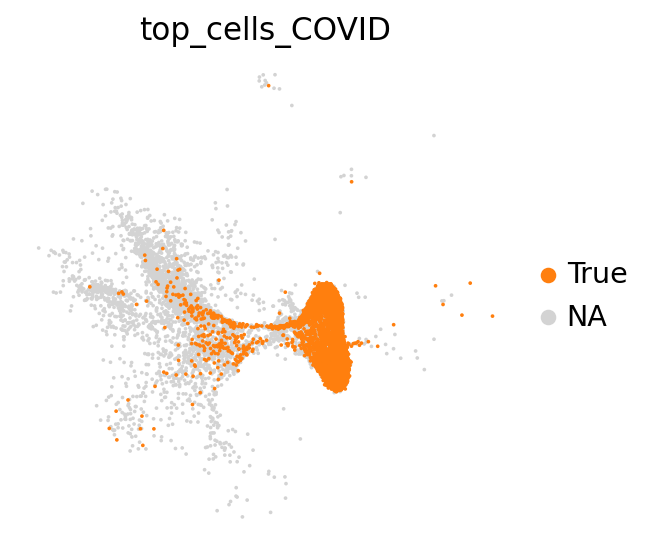

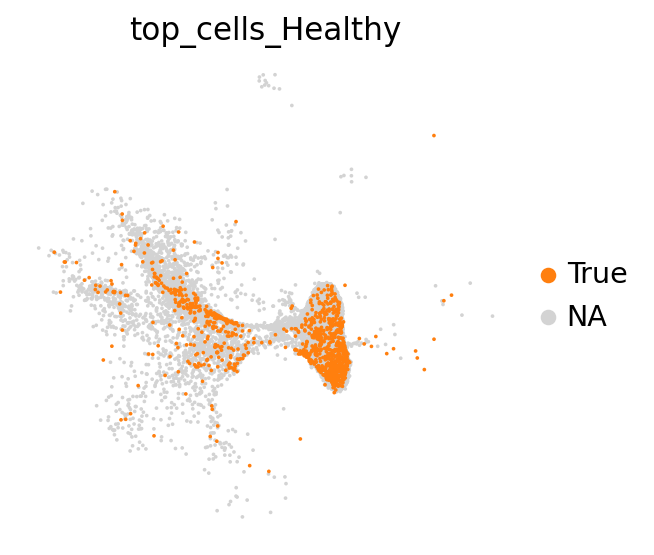

In [18]:
for cond in np.unique(plat.obs['Status_on_day_collection_summary']):
    sc.pl.umap(plat, color=[f'top_cells_{cond}'], groups=[True], frameon=False)

In [19]:
mono16 = adata[adata.obs['initial_clustering'].isin(['CD16'])].copy()
mono16

AnnData object with n_obs × n_vars = 10849 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn', 'top_cells_COVID', 'top_cells_Healthy'
    var: 'modality'
    uns: 'Site_colors', '_scvi_manager_uuid', '_scvi_uuid', 'full_clustering_colors', 'initial_clustering_colors', 'modality_lengths', 'neighbors', 'patient_id_colors', 'umap', 'top_cells_COVID_colors', 'top_cells_Healthy_colors'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'latent', 'latent_0', 'latent_1', 'la

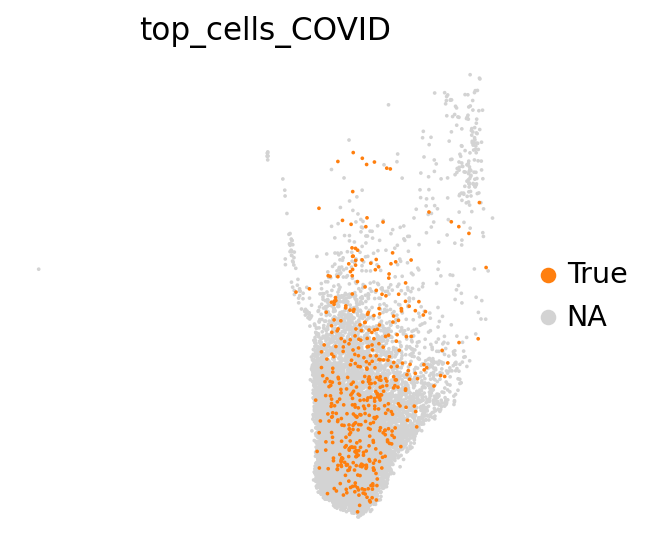

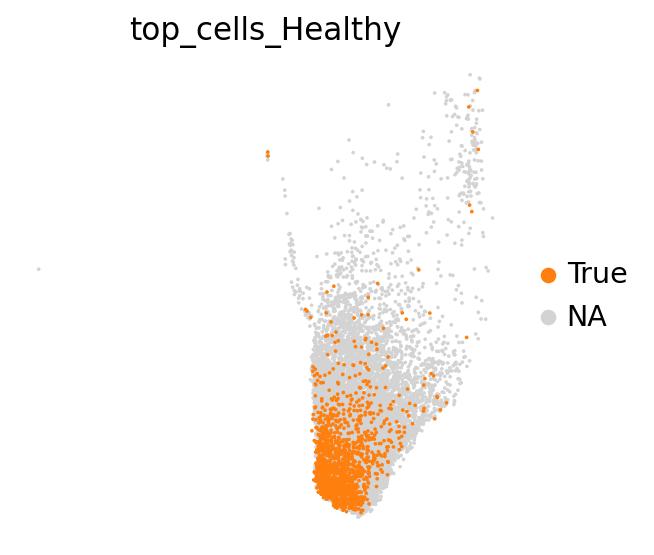

In [20]:
for cond in np.unique(mono16.obs['Status_on_day_collection_summary']):
    sc.pl.umap(mono16, color=[f'top_cells_{cond}'], groups=[True], frameon=False)

In [21]:
plas = adata[adata.obs['initial_clustering'] == 'Plasmablast'].copy()
plas

AnnData object with n_obs × n_vars = 5145 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn', 'top_cells_COVID', 'top_cells_Healthy'
    var: 'modality'
    uns: 'Site_colors', '_scvi_manager_uuid', '_scvi_uuid', 'full_clustering_colors', 'initial_clustering_colors', 'modality_lengths', 'neighbors', 'patient_id_colors', 'umap', 'top_cells_COVID_colors', 'top_cells_Healthy_colors'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'latent', 'latent_0', 'latent_1', 'lat

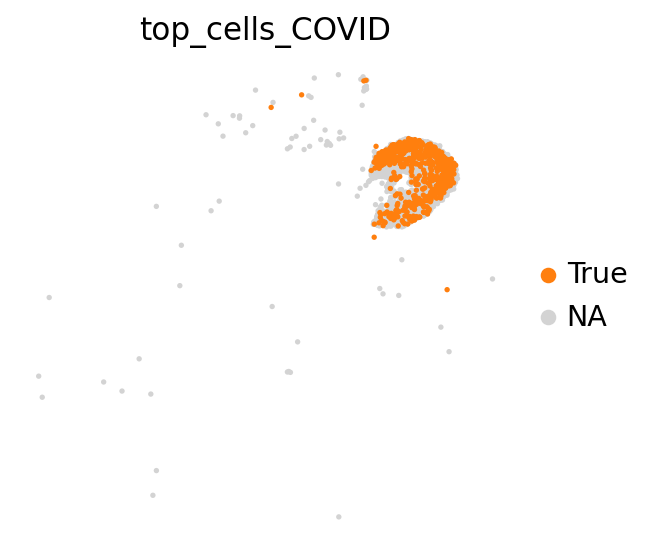

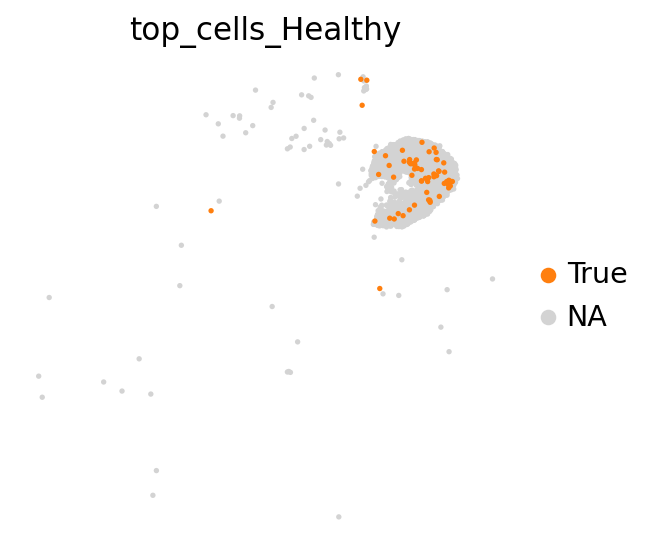

In [22]:
for cond in np.unique(plas.obs['Status_on_day_collection_summary']):
    sc.pl.umap(plas, color=[f'top_cells_{cond}'], groups=[True], frameon=False)

In [39]:
adata

AnnData object with n_obs × n_vars = 362426 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn', 'top_cells_COVID', 'top_cells_Healthy'
    var: 'modality'
    uns: 'Site_colors', 'Status_on_day_collection_summary_colors', '_scvi_manager_uuid', '_scvi_uuid', 'full_clustering_colors', 'initial_clustering_colors', 'modality_lengths', 'neighbors', 'patient_id_colors', 'umap', 'top_cells_COVID_colors', 'top_cells_Healthy_colors'
    obsm: 'X_umap', '_scvi_extra_categorical_

B_cell


KeyError: 'Could not find key top_cells_COVID in .var_names or .obs.columns.'

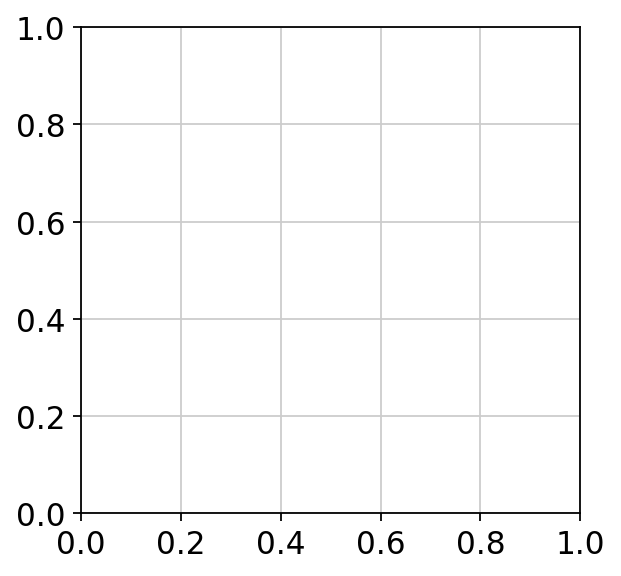

In [14]:
for ct in np.unique(adata.obs['initial_clustering']):
    print(ct)
    adata_tmp = adata[adata.obs['initial_clustering'] == ct].copy()
    for cond in np.unique(adata_tmp.obs['Status_on_day_collection_summary']):
        sc.pl.umap(adata_tmp, color=[f'top_cells_COVID'], groups=[True], frameon=False, color='red')
        sc.pl.umap(adata_tmp, color=[f'top_cells_COVID'], groups=[True], frameon=False, color='blue')
        

In [6]:
mono14 = adata[adata.obs['initial_clustering'] == 'CD14'].copy()
mono14

AnnData object with n_obs × n_vars = 61064 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    var: 'modality'
    uns: 'Site_colors', '_scvi_manager_uuid', '_scvi_uuid', 'full_clustering_colors', 'initial_clustering_colors', 'modality_lengths', 'neighbors', 'patient_id_colors', 'umap'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'latent', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
mono16 = adata[adata.obs['initial_clustering'] == 'CD16'].copy()
mono16

AnnData object with n_obs × n_vars = 10849 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    var: 'modality'
    uns: 'Site_colors', '_scvi_manager_uuid', '_scvi_uuid', 'full_clustering_colors', 'initial_clustering_colors', 'modality_lengths', 'neighbors', 'patient_id_colors', 'umap'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'latent', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

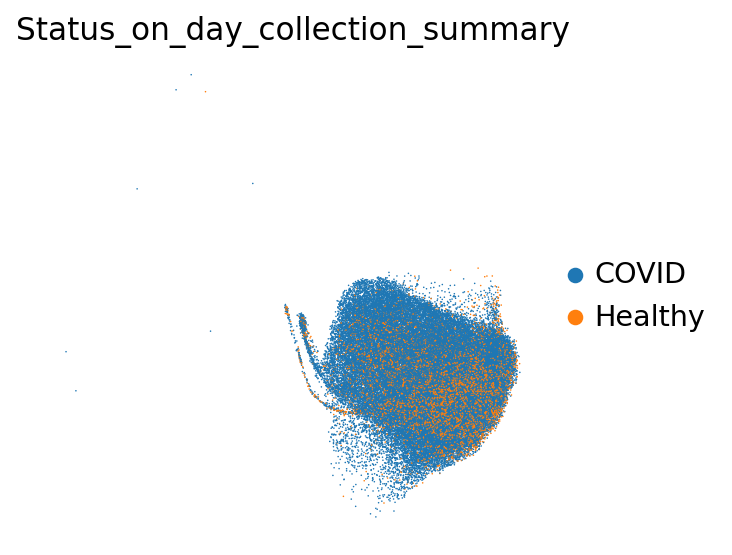

In [10]:
sc.pl.umap(mono14, color=['Status_on_day_collection_summary'], frameon=False, ncols=1)

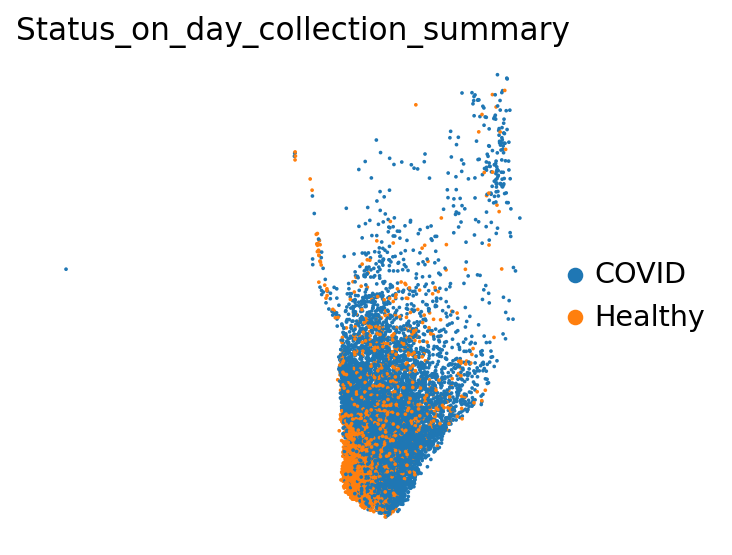

In [11]:
sc.pl.umap(mono16, color=['Status_on_day_collection_summary'], frameon=False, ncols=1)

In [12]:
mono16

AnnData object with n_obs × n_vars = 10849 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    var: 'modality'
    uns: 'Site_colors', '_scvi_manager_uuid', '_scvi_uuid', 'full_clustering_colors', 'initial_clustering_colors', 'modality_lengths', 'neighbors', 'patient_id_colors', 'umap', 'Status_on_day_collection_summary_colors'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'latent', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'
    layers: 'counts

In [ ]:
sc.pl.umap(mono16, color=[f'top_cells_'], groups=[True], frameon=False)

In [5]:
adata

AnnData object with n_obs × n_vars = 362426 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    var: 'modality'
    uns: 'Site_colors', 'Status_on_day_collection_summary_colors', '_scvi_manager_uuid', '_scvi_uuid', 'full_clustering_colors', 'initial_clustering_colors', 'modality_lengths', 'neighbors', 'patient_id_colors', 'umap'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'latent', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'
    layers: 'count

In [7]:
adata.obs['top_cells'] = False
for sample in np.unique(adata.obs['patient_id']):
    adata_tmp = adata[adata.obs['patient_id'] == sample].copy()
    threshold_idx = int(len(adata_tmp) * 0.9)
    threshold_value = sorted(adata_tmp.obs['cell_attn'])[threshold_idx]
    adata_tmp.obs['group'] = 'all cells'
    adata_tmp.obs.loc[adata_tmp.obs['cell_attn'] >= threshold_value, 'group'] = 'top 10% cells'
    # adata.obs[f'top_cells_{cond}'] = False
    adata.obs.loc[adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs_names, 'top_cells'] = True
    #adata.obs[f'top_cells_{cond}'] = adata.obs[f'top_cells_{cond}'].astype('category')
    #dfs.append(adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs[['initial_clustering', 'Status_on_day_collection_summary']])
adata.obs['top_cells'] = adata.obs['top_cells'].astype('category')

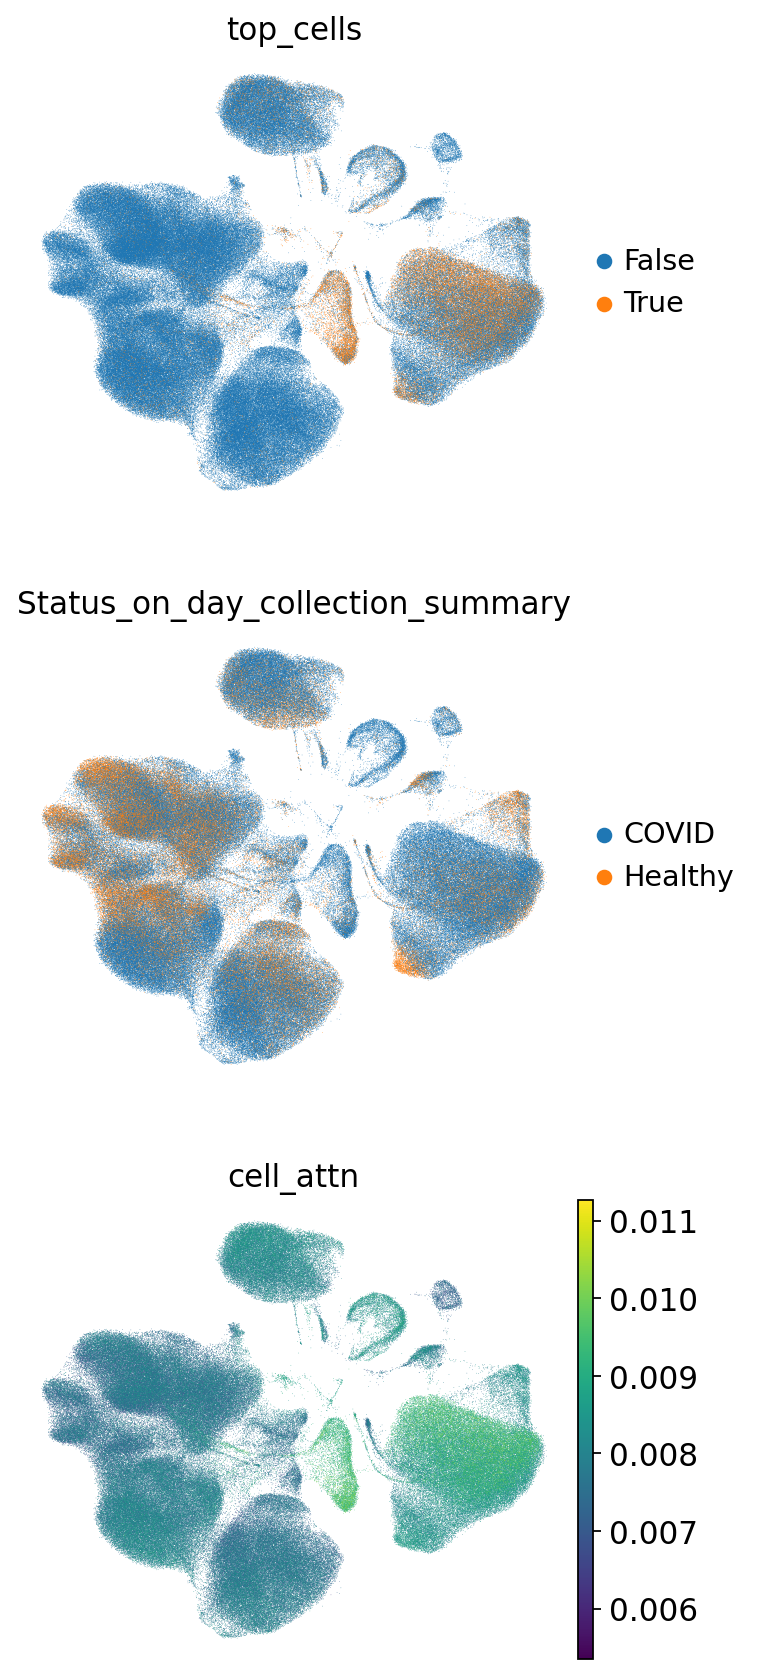

In [9]:
sc.pl.umap(adata, color=['top_cells', 'Status_on_day_collection_summary', 'cell_attn'], ncols=1, frameon=False,)

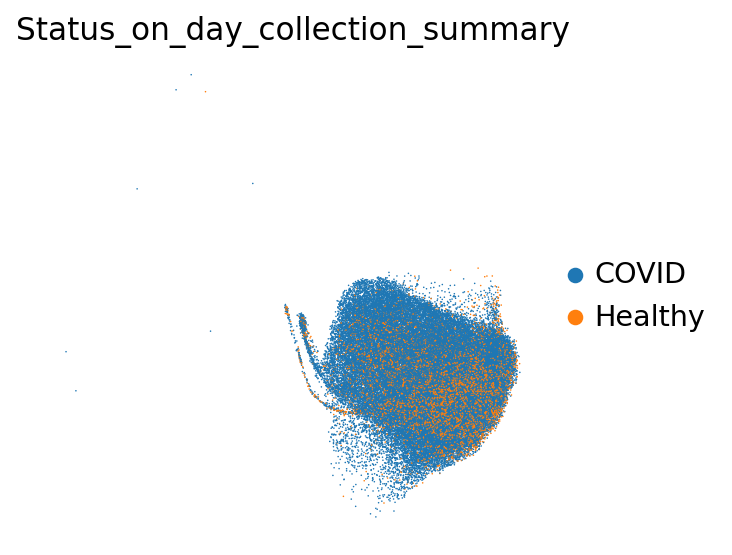

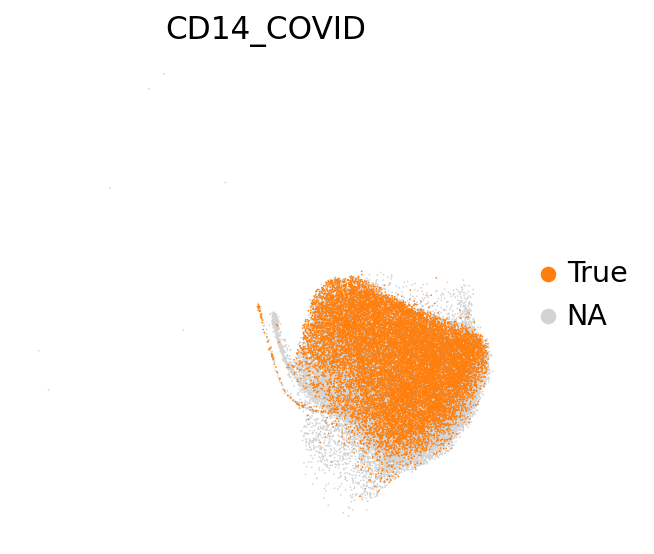

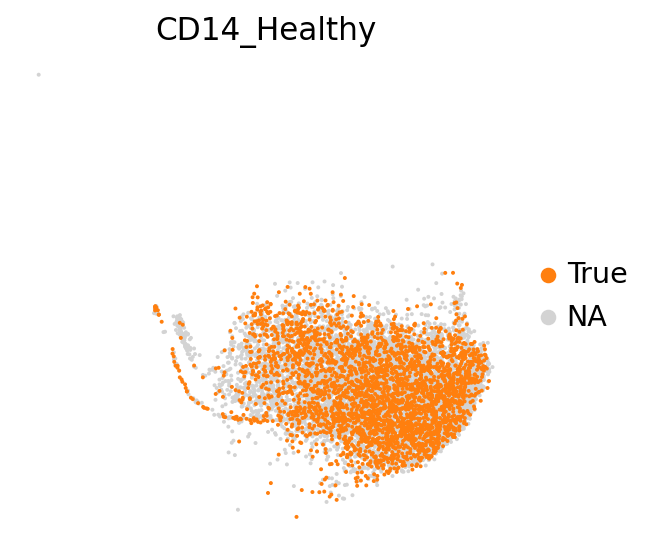

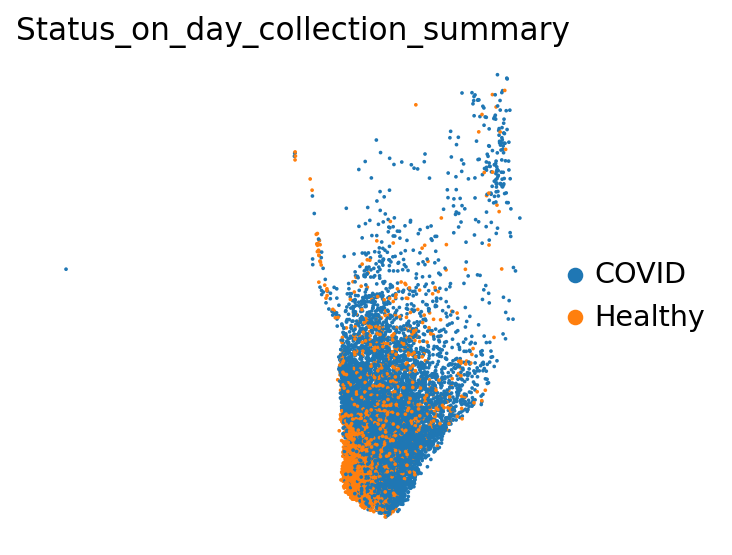

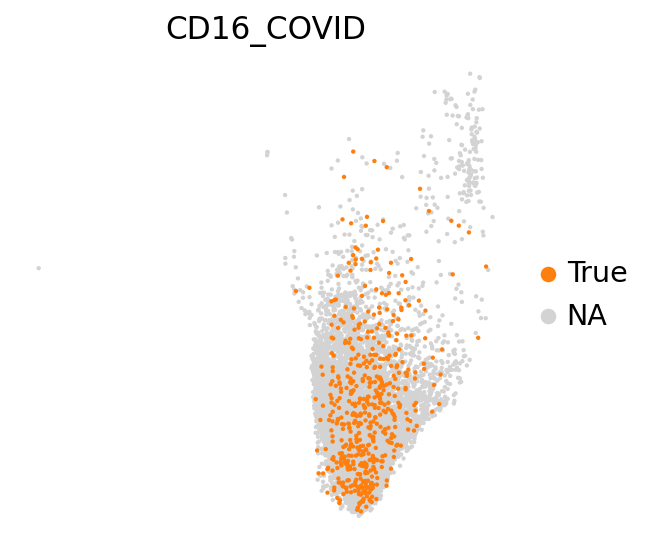

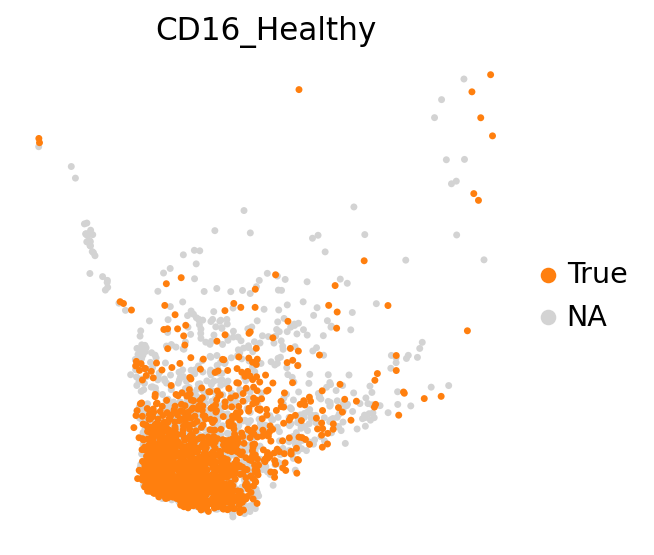

In [14]:
for ct in ['CD14', 'CD16']:
    adata_ct = adata[adata.obs['initial_clustering'] == ct].copy()
    sc.pl.umap(adata_ct, color='Status_on_day_collection_summary', frameon=False)
    for cond in np.unique(adata_ct.obs['Status_on_day_collection_summary']):
        adata_ct_cond = adata_ct[adata_ct.obs['Status_on_day_collection_summary'] == cond]
        sc.pl.umap(adata_ct_cond, color=['top_cells'], groups=[True], frameon=False, title=f'{ct}_{cond}')